### 1. ИМПОРТ НЕОБХОДИМЫХ БИБЛИОТЕК

In [38]:
import random
from datetime import datetime, timedelta

import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

---
#### ПОДКЛЮЧЕНИЕ К БД

In [39]:
# --- 1. ПАРАМЕТРЫ ПОДКЛЮЧЕНИЯ ---
DB_USER = "postgres"
DB_PASS = "postgres"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "mipt"

# Коннект через psycopg2 для вставки
dsn = f"dbname={DB_NAME} user={DB_USER} password={DB_PASS} host={DB_HOST} port={DB_PORT}"
conn = psycopg2.connect(dsn)
cur = conn.cursor()

# SQLAlchemy engine для pandas
engine_url = f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(engine_url)

---
#### 3. ГЕНЕРАЦИЯ И ВСТАВКА ДАННЫХ

In [40]:
now = datetime.utcnow()

# Пользователи
users = []
for _ in range(15):
    username = f"user{random.randint(1000,9999)}"
    email = f"{username}@example.com"
    password_hash = pd.util.hash_pandas_object(pd.Series([random.random()]), index=False).iloc[0]
    created_at = now - timedelta(days=random.uniform(0,365))
    users.append((username, email, str(password_hash), created_at))
cur.executemany(
    "INSERT INTO mipt_project.users(username,email,password_hash,created_at) VALUES(%s,%s,%s,%s)",
    users
)
conn.commit()

# Артисты
cur.execute("SELECT id FROM mipt_project.users")
user_ids = [r[0] for r in cur.fetchall()]
artists = []
for _ in range(15):
    name = f"Artist_{random.randint(1,999)}"
    bio = f"Bio text {random.randint(1000,9999)}"
    user_id = random.choice(user_ids)
    created_at = now - timedelta(days=random.uniform(0,365))
    artists.append((name, bio, user_id, created_at))
cur.executemany(
    "INSERT INTO mipt_project.artists(name,bio,user_id,created_at) VALUES(%s,%s,%s,%s)",
    artists
)
conn.commit()

# Альбомы
cur.execute("SELECT id FROM mipt_project.artists")
artist_ids = [r[0] for r in cur.fetchall()]
albums = []
for _ in range(15):
    artist_id = random.choice(artist_ids)
    title = f"Album_{random.randint(1,999)}"
    release_date = datetime(2020,1,1) + timedelta(days=random.randint(0,365*3))
    created_at = now - timedelta(days=random.uniform(0,365))
    albums.append((artist_id, title, release_date, created_at))
cur.executemany(
    "INSERT INTO mipt_project.albums(artist_id,title,release_date,created_at) VALUES(%s,%s,%s,%s)",
    albums
)
conn.commit()

# Треки
cur.execute("SELECT id FROM mipt_project.albums")
album_ids = [r[0] for r in cur.fetchall()]

# Счётчик по каждому альбому
album_counter = {aid: 0 for aid in album_ids}
tracks = []
for _ in range(15):
    aid = random.choice(album_ids)
    album_counter[aid] += 1
    tn = album_counter[aid]
    tracks.append((
        aid,
        f"Track_{aid}_{tn}",
        random.randint(120,400),
        tn,
        f"https://audio.example.com/{random.getrandbits(32):x}.mp3",
        now - timedelta(days=random.uniform(0,180))
    ))

cur.executemany(
    """
    INSERT INTO mipt_project.tracks
      (album_id, title, duration, track_number, track_url, created_at)
    VALUES (%s, %s, %s, %s, %s, %s)
    ON CONFLICT (album_id, track_number) DO NOTHING
    """,
    tracks
)
conn.commit()

# Плейлисты
cur.execute("SELECT id FROM mipt_project.albums")
album_ids = [r[0] for r in cur.fetchall()]
album_counts = {aid: 0 for aid in album_ids}
tracks = []
for _ in range(15):
    album_id = random.choice(album_ids)
    album_counts[album_id] += 1
    track_number = album_counts[album_id]
    title = f"Track_{album_id}_{track_number}"
    duration = random.randint(120,400)
    track_url = f"https://audio.example.com/{random.getrandbits(32):x}.mp3"
    created_at = now - timedelta(days=random.uniform(0,180))
    tracks.append((album_id, title, duration, track_number, track_url, created_at))

cur.executemany(
    """
    INSERT INTO mipt_project.tracks
      (album_id, title, duration, track_number, track_url, created_at)
    VALUES (%s, %s, %s, %s, %s, %s) ON CONFLICT DO NOTHING
    """,
    tracks
)
conn.commit()

# Track-Genres (пропускаем дубликаты)
cur.execute("SELECT id FROM mipt_project.tracks")
track_ids = [r[0] for r in cur.fetchall()]
cur.execute("SELECT id FROM mipt_project.genres")
genre_ids = [r[0] for r in cur.fetchall()]
tg_rel = []
max_genres = len(genre_ids)
for tid in track_ids:
    if max_genres == 0:
        break
    k = random.randint(1, min(3, max_genres))
    for gid in random.sample(genre_ids, k=k):
        tg_rel.append((tid, gid))
cur.executemany(
    "INSERT INTO mipt_project.track_genres(track_id,genre_id) VALUES(%s,%s) ON CONFLICT DO NOTHING",
    tg_rel
)
conn.commit()

# Playlist-Tracks (пропускаем дубликаты)
cur.execute("SELECT id FROM mipt_project.playlists")
pl_ids = [r[0] for r in cur.fetchall()]
pt_rel = []
for pid in pl_ids:
    sel = random.sample(track_ids, k=random.randint(3,5))
    for pos, tid in enumerate(sel, start=1):
        pt_rel.append((pid, tid, pos))
cur.executemany(
    "INSERT INTO mipt_project.playlist_tracks(playlist_id,track_id,position) VALUES(%s,%s,%s) ON CONFLICT DO NOTHING",
    pt_rel
)
conn.commit()

---
#### 4. АНАЛИТИЧЕСКИЕ ВЫБОРКИ

In [41]:
albums_df = pd.read_sql("SELECT id, title FROM mipt_project.albums", con=engine)
tracks_df = pd.read_sql(
    "SELECT id AS track_id, album_id, duration FROM mipt_project.tracks", con=engine
)
track_genres_df = pd.read_sql(
    "SELECT track_id, genre_id FROM mipt_project.track_genres", con=engine
)
genres_df = pd.read_sql(
    "SELECT id AS genre_id, name FROM mipt_project.genres", con=engine
)
playlists_df = pd.read_sql(
    "SELECT id AS playlist_id, user_id FROM mipt_project.playlists", con=engine
)
users_df = pd.read_sql(
    "SELECT id AS user_id, username FROM mipt_project.users", con=engine
)

tracks_per_album = (
    tracks_df.groupby('album_id')
    .size()
    .reset_index(name='track_count')
    .merge(albums_df, left_on='album_id', right_on='id')
)

tg = track_genres_df.merge(genres_df, on='genre_id')
tracks_per_genre = (
    tg.groupby('name')
    .size()
    .reset_index(name='track_count')
)

pl_per_user = (
    playlists_df.groupby('user_id')
    .size()
    .reset_index(name='playlists_count')
    .merge(users_df, on='user_id')
)


---
#### 5. ВИЗУАЛИЗАЦИЯ

C:\Users\rodin\AppData\Local\Temp\ipykernel_4528\1997124808.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='track_count', y='name', data=top5, palette='viridis')


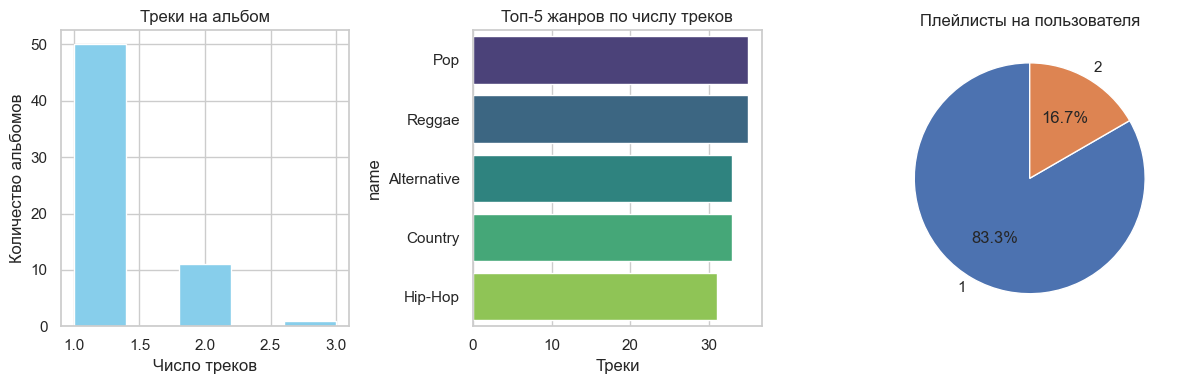

In [42]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 4))

# Гистограмма треков на альбом
plt.subplot(1, 3, 1)
tracks_per_album['track_count'].hist(bins=5, color='skyblue')
plt.title('Треки на альбом')
plt.xlabel('Число треков')
plt.ylabel('Количество альбомов')

# Столбчатая диаграмма топ-5 жанров
plt.subplot(1, 3, 2)
top5 = tracks_per_genre.sort_values('track_count', ascending=False).head(5)
sns.barplot(x='track_count', y='name', data=top5, palette='viridis')
plt.title('Топ-5 жанров по числу треков')
plt.xlabel('Треки')

# Круговая диаграмма плейлистов на пользователя
plt.subplot(1, 3, 3)
cnts = pl_per_user['playlists_count'].value_counts().sort_index()
plt.pie(cnts, labels=cnts.index.astype(str),
        autopct='%1.1f%%', startangle=90)
plt.title('Плейлисты на пользователя')

plt.tight_layout()
plt.savefig('analysis_plots.png')
plt.show()

---
#### 6. ПРОВЕРКА ГИПОТЕЗ

In [43]:
print("Гипотеза 1: Среднее число треков на альбом > 1")
avg_tracks = tracks_per_album['track_count'].mean()
print(f"Среднее: {avg_tracks:.2f}")
print("Подтверждена" if avg_tracks > 1 else "Не подтверждена")

print("\nГипотеза 2: Есть хотя бы один пользователь с более чем одним плейлистом")
multi_playlist_users = (pl_per_user['playlists_count'] > 1).any()
print("Подтверждена" if multi_playlist_users else "Не подтверждена")

print("\nГипотеза 3: Жанр 'Rock' лидирует по числу треков")
rock_count = tracks_per_genre.set_index('name').at['Rock', 'track_count']
max_other = tracks_per_genre[tracks_per_genre.name != 'Rock']['track_count'].max()
print(f"Rock: {rock_count}, Max остальных: {max_other}")
print("Подтверждена" if rock_count > max_other else "Не подтверждена")

Гипотеза 1: Среднее число треков на альбом > 1
Среднее: 1.21
Подтверждена

Гипотеза 2: Есть хотя бы один пользователь с более чем одним плейлистом
Подтверждена

Гипотеза 3: Жанр 'Rock' лидирует по числу треков
Rock: 29, Max остальных: 35
Не подтверждена


---
#### 5. ВЫВОДЫ

In [44]:
print("\nВыводы:")
print(f"1. Среднее число треков на альбом: {avg_tracks:.2f}.")
print("   - Гипотеза 1 " + ("верна." if avg_tracks > 1 else "ложна."))
print(f"2. Пользователи с более чем одним плейлистом: {'есть' if multi_playlist_users else 'нет'}.")
print("   - Гипотеза 2 " + ("верна." if multi_playlist_users else "ложна."))
print(f"3. Жанр 'Rock' {'лидирует' if rock_count > max_other else 'не лидирует'} по числу треков.")
print("   - Гипотеза 3 " + ("верна." if rock_count > max_other else "ложна."))


Выводы:
1. Среднее число треков на альбом: 1.21.
   - Гипотеза 1 верна.
2. Пользователи с более чем одним плейлистом: есть.
   - Гипотеза 2 верна.
3. Жанр 'Rock' не лидирует по числу треков.
   - Гипотеза 3 ложна.


---
#### 6. ЗАКРЫВАЕМ СОЕДИНЕНИЕ

In [45]:
conn.close()